In [ ]:
# Dataset Link: https://www.kaggle.com/datasets/pmigdal/alien-vs-predator-images

# Custom Model

In [9]:
# Step 1: Import Libraries

import os
from time import time
from tqdm import tqdm
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import DataLoader

from torchvision.datasets import ImageFolder
from torchvision.transforms import transforms

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
# Step 2: Data Loader

tfm = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]),
    ]
)

TRAIN_PATH = "data/train/"
VAL_PATH = "data/validation/"

train_ds = ImageFolder(root=TRAIN_PATH, transform=tfm)
val_ds = ImageFolder(root=VAL_PATH, transform=tfm)

train_loader = DataLoader(train_ds, batch_size=10, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=10, shuffle=True)

In [3]:
# Step 3: Create Model


class AVPCNN(nn.Module):
    def __init__(self, in_params, out_params):
        super(AVPCNN, self).__init__()
        # Convolution Layer
        self.conv = nn.Conv2d(
            in_channels=in_params, out_channels=8, kernel_size=3, stride=1, padding=1
        )
        self.pool = nn.AvgPool2d(kernel_size=3, stride=1)
        self.relu = nn.LeakyReLU()
        self.bn = nn.BatchNorm2d(num_features=8)
        self.drop = nn.Dropout2d(p=0.4)

        # Fully Connected Layer
        self.fc = nn.Linear(in_features=8 * 222 * 222, out_features=2)

    def forward(self, X):
        output = self.conv(X)
        output = self.pool(output)
        output = self.relu(output)
        output = self.bn(output)
        output = self.drop(output)
        #         print(output.shape)
        output = output.view(-1, 8 * 222 * 222)
        output = self.fc(output)
        return output

In [4]:
# Instantiate the model

model = AVPCNN(in_params=3, out_params=2)
model = model.cuda()

In [5]:
# Step 5: Train the Model

# Define Optimiser and Loss Function

loss_function = nn.CrossEntropyLoss()
optimiser = Adam(model.parameters(), lr=3e-4, weight_decay=0.0001)
TRAIN_SIZE = len(train_ds)
VAL_SIZE = len(val_ds)

# empty Cuda cache
torch.cuda.empty_cache()

In [7]:
loss_train_list = []
acc_train_list = []
loss_val_list = []
acc_val_list = []


for epoch in range(10):
    start = time()

    tr_acc = 0
    val_acc = 0

    # Training Phase

    model.train()
    with tqdm(train_loader, unit="batch") as tepoch:
        for xtrain, ytrain in tepoch:
            optimiser.zero_grad()
            xtrain = xtrain.cuda()
            ytrain_pred = model(xtrain)
            ytrain_pred = ytrain_pred.cpu()
            loss_train = loss_function(ytrain_pred, ytrain)
            loss_train.backward()
            optimiser.step()

            train_pred = torch.max(ytrain_pred, 1).indices
            tr_acc += int(torch.sum(train_pred == ytrain))
        ep_tr_acc = tr_acc / TRAIN_SIZE

    # Evaluation Phase

    model.eval()
    for xval, yval in val_loader:
        xval = xval.cuda()
        xval_pred = model(xval)
        xval_pred = xval_pred.cpu()
        loss_val = loss_function(xval_pred, yval)
        train_val = torch.max(xval_pred, 1).indices
        val_acc += int(torch.sum(train_val == yval))
    ep_val_acc = val_acc / VAL_SIZE

    loss_train_list.append(loss_train)
    acc_train_list.append(ep_tr_acc)
    loss_val_list.append(loss_val)
    acc_val_list.append(ep_val_acc)

    end = time()
    dur = end - start
    print(
        f"Ep:{epoch}, Time:{dur}\ntr_acc:{ep_tr_acc}, val_acc:{ep_val_acc},\ntr_loss:{loss_train},val_loss:{loss_val}"
    )

100%|███████████████████████████████████████████████████████████████████████████████| 70/70 [00:05<00:00, 11.81batch/s]


Ep:0, Time:6.573369741439819
tr_acc:0.5965417867435159, val_acc:0.52,
tr_loss:34.2791748046875,val_loss:6.715303897857666


100%|███████████████████████████████████████████████████████████████████████████████| 70/70 [00:02<00:00, 25.23batch/s]


Ep:1, Time:3.4664158821105957
tr_acc:0.6512968299711815, val_acc:0.63,
tr_loss:0.0012460852740332484,val_loss:2.4037070274353027


100%|███████████████████████████████████████████████████████████████████████████████| 70/70 [00:02<00:00, 27.77batch/s]


Ep:2, Time:3.1552200317382812
tr_acc:0.6772334293948127, val_acc:0.53,
tr_loss:0.00011700906907208264,val_loss:9.583066940307617


100%|███████████████████████████████████████████████████████████████████████████████| 70/70 [00:02<00:00, 26.69batch/s]


Ep:3, Time:3.288466453552246
tr_acc:0.7564841498559077, val_acc:0.64,
tr_loss:2.6462292671203613,val_loss:5.001847267150879


100%|███████████████████████████████████████████████████████████████████████████████| 70/70 [00:02<00:00, 25.35batch/s]


Ep:4, Time:3.510890483856201
tr_acc:0.7780979827089337, val_acc:0.645,
tr_loss:0.1361427754163742,val_loss:10.268289566040039


100%|███████████████████████████████████████████████████████████████████████████████| 70/70 [00:03<00:00, 22.58batch/s]


Ep:5, Time:3.9358761310577393
tr_acc:0.7694524495677233, val_acc:0.565,
tr_loss:0.0,val_loss:8.731955528259277


100%|███████████████████████████████████████████████████████████████████████████████| 70/70 [00:03<00:00, 22.60batch/s]


Ep:6, Time:3.9417810440063477
tr_acc:0.8126801152737753, val_acc:0.615,
tr_loss:22.36250114440918,val_loss:7.928706169128418


100%|███████████████████████████████████████████████████████████████████████████████| 70/70 [00:03<00:00, 22.53batch/s]


Ep:7, Time:3.9236409664154053
tr_acc:0.840057636887608, val_acc:0.635,
tr_loss:2.9802320611338473e-08,val_loss:4.628108024597168


100%|███████████████████████████████████████████████████████████████████████████████| 70/70 [00:03<00:00, 22.75batch/s]


Ep:8, Time:3.90910267829895
tr_acc:0.8760806916426513, val_acc:0.595,
tr_loss:2.3397586345672607,val_loss:5.8128437995910645


100%|███████████████████████████████████████████████████████████████████████████████| 70/70 [00:03<00:00, 22.50batch/s]


Ep:9, Time:3.9513604640960693
tr_acc:0.8587896253602305, val_acc:0.63,
tr_loss:4.5137434005737305,val_loss:3.8691182136535645


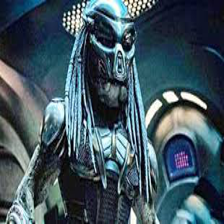

Predator


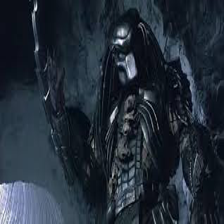

Predator


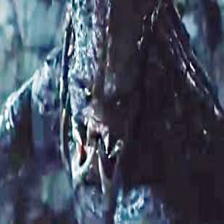

Alien


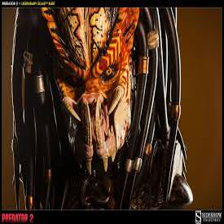

Predator


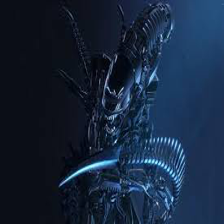

Alien


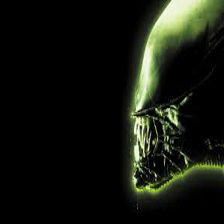

Alien


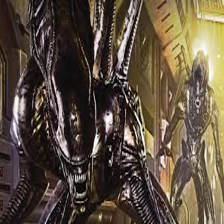

Alien


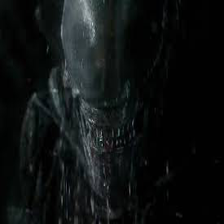

Alien


In [14]:
# Step 5: Model Performance
predator_sample_1 = "data/validation/predator/0.jpg"
predator_sample_2 = "data/validation/predator/26.jpg"
predator_sample_3 = "data/validation/predator/4.jpg"
predator_sample_4 = "data/validation/predator/54.jpg"
alien_sample_1 = "data/validation/alien/0.jpg"
alien_sample_2 = "data/validation/alien/34.jpg"
alien_sample_3 = "data/validation/alien/48.jpg"
alien_sample_4 = "data/validation/alien/85.jpg"

pathlist = [
    predator_sample_1,
    predator_sample_2,
    predator_sample_3,
    predator_sample_4,
    alien_sample_1,
    alien_sample_2,
    alien_sample_3,
    alien_sample_4,
]


for path in pathlist:
    img = Image.open(path)
    img = img.resize((224, 224))
    display(img)
    img_array = tfm(img)
    img_tensor = img_array[np.newaxis, :]
    img_tensor = img_tensor.cuda()
    y_pred = model(img_tensor.float())
    y_pred = y_pred.cpu()
    output = torch.max(y_pred, 1).indices
    output = output.item()
    if output == 1:
        print("Predator")
    else:
        print("Alien")
    print("=======================================")

---

## Author:
Notebook by Shounak Deshpande<br>
Email: shounak.python@gmail.com